In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [ ]:
import plotly.offline as pyoff
import plotly.graph_objs as go

Customer segmentation:
- RFM scores: recency, frequency and revenue
- 3 segmenets: (i) low value, (ii) mid value and (iii) high value

# Data

In [ ]:
# retail_df
retail_df = pd.read_csv('data/OnlineRetail.csv', encoding='unicode_escape')
## 'InvoiceDate': convert to datetime
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'])
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
# retail_UK_df
# retail_UK_df = retail_df.query('Country == "United Kingdom"')
retail_UK_df = retail_df.loc[retail_df['Country'] == 'United Kingdom']
retail_UK_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# create user_UK_df
user_UK_df = pd.DataFrame(retail_UK_df['CustomerID'].unique())
user_UK_df.columns = ['CustomerID']
user_UK_df.head()

,CustomerID
0,17850.0
1,13047.0
2,13748.0
3,15100.0
4,15291.0


In [ ]:
print('user_UK_df has {} rows and {} columns'.format(user_UK_df.shape[0], user_UK_df.shape[1]))

user_UK_df has 3951 rows and 1 columns


# Recency
- find out most recent purchase date of each customer
- calculate recency: number of inactive days
- plot histogram
- apply Kmeans clustering (ordered) to get recency score

In [ ]:
# create last_purchase_date
last_purchase_date = retail_UK_df.groupby(['CustomerID'])['InvoiceDate'].max()
last_purchase_date = last_purchase_date.reset_index()
last_purchase_date.head()

,CustomerID,InvoiceDate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00


In [ ]:
# calculate recency
## recency: number of inactive days
last_purchase_date['Recency'] = last_purchase_date['InvoiceDate'].max() - last_purchase_date['InvoiceDate']
last_purchase_date['Recency'] = last_purchase_date['Recency'].dt.days
last_purchase_date.head()

,CustomerID,InvoiceDate,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12747.0,2011-12-07 14:34:00,1
2,12748.0,2011-12-09 12:20:00,0
3,12749.0,2011-12-06 09:56:00,3
4,12820.0,2011-12-06 15:12:00,2


In [ ]:
# merge with user_UK_df: recency for each customer
user_UK_df = pd.merge(user_UK_df, last_purchase_date[['CustomerID', 'Recency']], on='CustomerID')
user_UK_df.head()

,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,13748.0,95
3,15100.0,329
4,15291.0,25


In [ ]:
# describe 'Recency'
user_UK_df['Recency'].describe()

count    3950.000000
mean       90.778481
std       100.230349
min         0.000000
25%        16.000000
50%        49.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

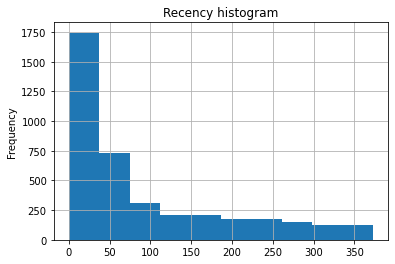

In [ ]:
# plot 'Recency' histogram
user_UK_df['Recency'].plot(kind='hist', grid=True, title='Recency histogram')
plt.show()

In [ ]:
# plotly
plot_data = [
    go.Histogram(
        x=user_UK_df['Recency']
    )
]

plot_layout = go.Layout(
    title='Recency histogram'
)

fig=go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

## Kmeans clustering
- how many clusters: Elbow method
- order clusters

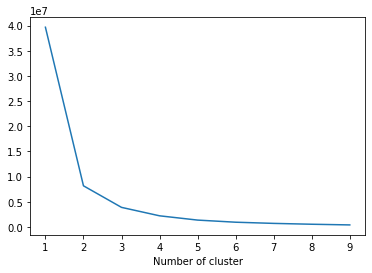

In [ ]:
# indentify number of clusters
## Elbow method
from sklearn.cluster import KMeans

recency = user_UK_df[['Recency']]
sse = {}

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(recency)
    sse[i] = kmeans.inertia_ # sum of squared distances of samples to closest cluster center

## plot: n_clusters=4
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of cluster')
plt.show()

In [ ]:
# apply Kmeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(user_UK_df[['Recency']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
# create 'RecencyCluster' as recency score
user_UK_df['RecencyCluster'] = kmeans.predict(user_UK_df[['Recency']])
user_UK_df.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,301,1
1,13047.0,31,2
2,13748.0,95,0
3,15100.0,329,1
4,15291.0,25,2


In [ ]:
# clusters not in order
user_UK_df.groupby(['RecencyCluster'])['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,954.0,77.679245,22.850898,48.0,59.00,72.5,93.00,131.0
1,478.0,304.393305,41.183489,245.0,266.25,300.0,336.00,373.0
2,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.00,47.0
3,568.0,184.625000,31.753602,132.0,156.75,184.0,211.25,244.0


In [ ]:
# function for ordering cluster numbers
## ascending: True in case the higher target value, the higher score
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={'index': cluster_field_name})

    return df_final

In [ ]:
# get clusters ordered
user_UK_df = order_cluster('RecencyCluster', 'Recency', user_UK_df, ascending=False)
user_UK_df.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,301,0
1,15100.0,329,0
2,18074.0,373,0
3,16250.0,260,0
4,13747.0,373,0


In [ ]:
# cluster profile
user_UK_df.groupby(['RecencyCluster'])['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,478.0,304.393305,41.183489,245.0,266.25,300.0,336.00,373.0
1,568.0,184.625000,31.753602,132.0,156.75,184.0,211.25,244.0
2,954.0,77.679245,22.850898,48.0,59.00,72.5,93.00,131.0
3,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.00,47.0


# Frequency
- calculate frequency: total number of orders for each customer
- plot histogram
- apply Kmeans clustering (ordered) to get frequency score

In [ ]:
# calculate frequency
## frequency = total number of orders
frequency = retail_UK_df.groupby(['CustomerID'])['Quantity'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'Frequency']
frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12747.0,103
2,12748.0,4642
3,12749.0,231
4,12820.0,59


In [ ]:
# merge with user_UK_df
user_UK_df = pd.merge(user_UK_df, frequency, on='CustomerID')
user_UK_df.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,301,0,312
1,15100.0,329,0,6
2,18074.0,373,0,13
3,16250.0,260,0,24
4,13747.0,373,0,1


In [ ]:
# describe 'Frequency'
user_UK_df['Frequency'].describe()

count    3950.000000
mean       91.614684
std       220.557389
min         1.000000
25%        17.000000
50%        41.000000
75%       101.000000
max      7983.000000
Name: Frequency, dtype: float64

In [ ]:
# plot 'Frequency' histogram
plot_data = [
    go.Histogram(
        x=user_UK_df['Frequency']
    )
]

plot_layout = go.Layout(
    title='Frequency histogram'
)

fig=go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

## Kmeans clustering
- how many clusters: Elbow method
- order clusters

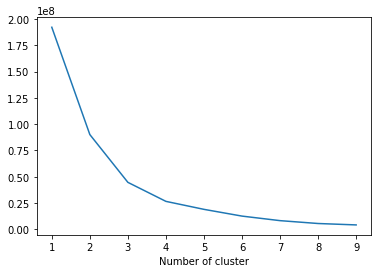

In [ ]:
# indentify number of clusters
## Elbow method
from sklearn.cluster import KMeans

frequency = user_UK_df[['Frequency']]
sse = {}

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(frequency)
    sse[i] = kmeans.inertia_

## plot
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of cluster')
plt.show() # optimal number = 4

In [ ]:
# apply Kmeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(user_UK_df[['Frequency']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
# create 'FrequencyCluster' as frequency score
user_UK_df['FrequencyCluster'] = kmeans.predict(user_UK_df[['Frequency']])
user_UK_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,17850.0,301,0,312,0
1,15100.0,329,0,6,2
2,18074.0,373,0,13,2
3,16250.0,260,0,24,2
4,13747.0,373,0,1,2


In [ ]:
# clusters not in order
user_UK_df.groupby(['FrequencyCluster'])['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,429.0,331.221445,133.856510,191.0,228.0,287.0,399.0,803.0
1,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.5,7983.0
2,3496.0,49.525744,44.954212,1.0,15.0,33.0,73.0,190.0
3,22.0,1313.136364,505.934524,872.0,988.5,1140.0,1452.0,2782.0


In [ ]:
# get clusters ordered
user_UK_df = order_cluster('FrequencyCluster', 'Frequency', user_UK_df, ascending=True)
user_UK_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,17850.0,301,0,312,1
1,15808.0,305,0,210,1
2,13047.0,31,3,196,1
3,14688.0,7,3,359,1
4,16029.0,38,3,274,1


In [ ]:
# cluster profile
user_UK_df.groupby(['FrequencyCluster'])['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3496.0,49.525744,44.954212,1.0,15.0,33.0,73.0,190.0
1,429.0,331.221445,133.856510,191.0,228.0,287.0,399.0,803.0
2,22.0,1313.136364,505.934524,872.0,988.5,1140.0,1452.0,2782.0
3,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.5,7983.0


# Monetary value (revenue)
- calculate revenue for each customer
- plot histogram
- apply Kmeans (ordered) to get revenue score

In [ ]:
# create 'Revenue' for retail_UK_df
retail_UK_df['Revenue'] = retail_UK_df['UnitPrice'] * retail_UK_df['Quantity']
retail_UK_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [ ]:
# calculate revenue
## revenue: total revenue
revenue = retail_UK_df.groupby(['CustomerID'])['Revenue'].sum()
revenue = revenue.reset_index()
revenue.head()

,CustomerID,Revenue
0,12346.0,0.00
1,12747.0,4196.01
2,12748.0,29072.10
3,12749.0,3868.20
4,12820.0,942.34


In [ ]:
# merge with user_UK_df
user_UK_df = pd.merge(user_UK_df, revenue, on='CustomerID')
user_UK_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,17850.0,301,0,312,1,5288.63
1,15808.0,305,0,210,1,3724.77
2,13047.0,31,3,196,1,3079.10
3,14688.0,7,3,359,1,5107.38
4,16029.0,38,3,274,1,50992.61


In [ ]:
# describe 'Revenue'
user_UK_df['Revenue'].describe()

count      3950.000000
mean       1713.385669
std        6548.608224
min       -4287.630000
25%         282.255000
50%         627.060000
75%        1521.782500
max      256438.490000
Name: Revenue, dtype: float64

In [ ]:
# plot histogram
plot_data = [
    go.Histogram(
        x=user_UK_df['Revenue']
    )
]

plot_layout = go.Layout(
    title = 'Monetary value histogram'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

## Kmeans clustering
- how many clusters: Elbow method
- order clusters

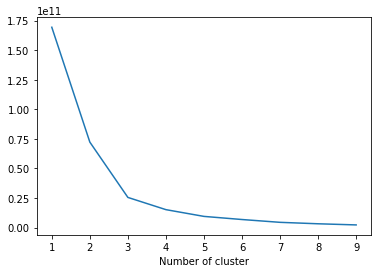

In [ ]:
# indentify number of clusters
## Elbow method
from sklearn.cluster import KMeans

revenue = user_UK_df[['Revenue']]
sse = {}

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(revenue)
    sse[i] = kmeans.inertia_

## plot
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of cluster')
plt.show() # optimal number = 4

In [ ]:
# apply Kmeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(user_UK_df[['Revenue']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
# create 'RevenueCluster' as monetary value score
user_UK_df['RevenueCluster'] = kmeans.predict(user_UK_df[['Revenue']])
user_UK_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,17850.0,301,0,312,1,5288.63,3
1,15808.0,305,0,210,1,3724.77,0
2,13047.0,31,3,196,1,3079.10,0
3,14688.0,7,3,359,1,5107.38,3
4,16029.0,38,3,274,1,50992.61,2


In [ ]:
# clusters not in order
user_UK_df.groupby(['RevenueCluster'])['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3687.0,907.254414,921.910820,-4287.63,263.115,572.56,1258.220,4314.72
1,2.0,221960.330000,48759.481478,187482.17,204721.250,221960.33,239199.410,256438.49
2,27.0,43070.445185,15939.249588,25748.35,28865.490,36351.42,53489.790,88125.38
3,234.0,7760.699530,3637.173671,4330.67,5161.485,6549.38,9142.305,21535.90


In [ ]:
# get clusters ordered
user_UK_df = order_cluster('RevenueCluster', 'Revenue', user_UK_df, ascending=True)
user_UK_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,17850.0,301,0,312,1,5288.63,1
1,14688.0,7,3,359,1,5107.38,1
2,13767.0,1,3,399,1,16945.71,1
3,15513.0,30,3,314,1,14520.08,1
4,14849.0,21,3,392,1,7904.28,1


In [ ]:
user_UK_df.groupby(['RevenueCluster'])['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3687.0,907.254414,921.910820,-4287.63,263.115,572.56,1258.220,4314.72
1,234.0,7760.699530,3637.173671,4330.67,5161.485,6549.38,9142.305,21535.90
2,27.0,43070.445185,15939.249588,25748.35,28865.490,36351.42,53489.790,88125.38
3,2.0,221960.330000,48759.481478,187482.17,204721.250,221960.33,239199.410,256438.49


# Overall score
- we have scores for recency, frequency and revenue
- calculate overall score
- name scores into 3 groups: (i) low value, (ii) mid value and (iii) high value
- scatter plots

In [ ]:
# calculate overall score
user_UK_df['OverallScore'] = user_UK_df['RecencyCluster'] + user_UK_df['FrequencyCluster'] + user_UK_df['RevenueCluster']
user_UK_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore
0,17850.0,301,0,312,1,5288.63,1,2
1,14688.0,7,3,359,1,5107.38,1,5
2,13767.0,1,3,399,1,16945.71,1,5
3,15513.0,30,3,314,1,14520.08,1,5
4,14849.0,21,3,392,1,7904.28,1,5


In [ ]:
# user profile
user_UK_df.groupby(['OverallScore'])[['Recency', 'Frequency', 'Revenue']].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,304.584388,21.995781,303.339705
1,185.362989,32.596085,498.087546
2,78.991304,46.963043,868.082991
3,20.689610,68.419590,1091.416414
4,14.892617,271.755034,3607.097114
5,9.662162,373.290541,9136.946014
6,7.740741,876.037037,22777.914815
7,1.857143,1272.714286,103954.025714
8,1.333333,5917.666667,42177.930000


## Divide into segments based on overall score
- 0-2: low value
- 3-4: mid value
- 5+: high value

In [ ]:
# segmentation
user_UK_df['Segment'] = 'Low-Value'
user_UK_df.loc[user_UK_df['OverallScore'] > 2, 'Segment'] = 'Mid-Value'
user_UK_df.loc[user_UK_df['OverallScore'] > 4, 'Segment'] = 'High-Value'
user_UK_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,0,312,1,5288.63,1,2,Low-Value
1,14688.0,7,3,359,1,5107.38,1,5,High-Value
2,13767.0,1,3,399,1,16945.71,1,5,High-Value
3,15513.0,30,3,314,1,14520.08,1,5,High-Value
4,14849.0,21,3,392,1,7904.28,1,5,High-Value


In [ ]:
user_UK_df['Segment'].value_counts()

Low-Value     1956
Mid-Value     1809
High-Value     185
Name: Segment, dtype: int64

In [ ]:
# user profile
user_UK_df.groupby(['Segment'])[['Recency', 'Frequency', 'Revenue']].mean()

,Recency,Frequency,Revenue
Segment,,,
High-Value,8.951351,570.605405,15251.263135
Low-Value,164.222393,36.784765,624.920538
Mid-Value,19.734660,101.915423,1505.829265


## Scatter plots

In [ ]:
graph = user_UK_df.query('Revenue < 50000 and Frequency < 2000')

In [ ]:
# Revenue vs Frequency
plot_data = [
    go.Scatter(
        x=graph.query('Segment == "Low-Value"')['Frequency'],
        y=graph.query('Segment == "Low-Value"')['Revenue'],
        mode='markers',
        name='Low',
        marker=dict(
            size=7,
            line=dict(width=1),
            color='blue',
            opacity=0.8
        )
    ),
    go.Scatter(
        x=graph.query('Segment == "Mid-Value"')['Frequency'],
        y=graph.query('Segment == "Mid-Value"')['Revenue'],
        mode='markers',
        name='Mid',
        marker=dict(
            size=9,
            line=dict(width=1),
            color='green',
            opacity=0.5
        )
    ),
    go.Scatter(
        x=graph.query('Segment == "High-Value"')['Frequency'],
        y=graph.query('Segment == "High-Value"')['Revenue'],
        mode='markers',
        name='High',
        marker=dict(
            size=11,
            line=dict(width=1),
            color='red',
            opacity=0.9
        )
    )
]

plot_layout = go.Layout(
    xaxis={'title': 'Frequency'},
    yaxis={'title': 'Revenue'},
    title='Segments'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
# Revenue vs Recency
plot_data = [
    go.Scatter(
        x=graph.query('Segment == "Low-Value"')['Recency'],
        y=graph.query('Segment == "Low-Value"')['Revenue'],
        mode='markers',
        name='Low',
        marker=dict(
            size=7,
            line=dict(width=1),
            color='blue',
            opacity=0.8
        )
    ),
    go.Scatter(
        x=graph.query('Segment == "Mid-Value"')['Recency'],
        y=graph.query('Segment == "Mid-Value"')['Revenue'],
        mode='markers',
        name='Mid',
        marker=dict(
            size=9,
            line=dict(width=1),
            color='green',
            opacity=0.5
        )
    ),
    go.Scatter(
        x=graph.query('Segment == "High-Value"')['Recency'],
        y=graph.query('Segment == "High-Value"')['Revenue'],
        mode='markers',
        name='High',
        marker=dict(
            size=11,
            line=dict(width=1),
            color='red',
            opacity=0.9
        )
    )
]

plot_layout = go.Layout(
    xaxis={'title': 'Recency'},
    yaxis={'title': 'Revenue'},
    title='Segments'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
# Frequency vs Recency
plot_data = [
    go.Scatter(
        x=graph.query('Segment == "Low-Value"')['Recency'],
        y=graph.query('Segment == "Low-Value"')['Frequency'],
        mode='markers',
        name='Low',
        marker=dict(
            size=7,
            line=dict(width=1),
            color='blue',
            opacity=0.8
        )
    ),
    go.Scatter(
        x=graph.query('Segment == "Mid-Value"')['Recency'],
        y=graph.query('Segment == "Mid-Value"')['Frequency'],
        mode='markers',
        name='Mid',
        marker=dict(
            size=9,
            line=dict(width=1),
            color='green',
            opacity=0.5
        )
    ),
    go.Scatter(
        x=graph.query('Segment == "High-Value"')['Recency'],
        y=graph.query('Segment == "High-Value"')['Frequency'],
        mode='markers',
        name='High',
        marker=dict(
            size=11,
            line=dict(width=1),
            color='red',
            opacity=0.9
        )
    )
]

plot_layout = go.Layout(
    xaxis={'title': 'Recency'},
    yaxis={'title': 'Frequency'},
    title='Segments'
)

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)